# Waldorf and Statler Audio

We will reuse the MFCC features already created for the Kermit approach for detecting W+S

In [ ]:
!python --version
!conda list |grep -E "pandas|numpy|seaborn|librosa|opencv|scikit"

In [3]:
import pandas as pd
import numpy as np
import os.path
import matplotlib.pyplot as plt

In [4]:
# DATA loading and splitting
train_data = pd.read_csv('../data/ep1_flat_mfcc.csv', sep=',', dtype=np.float64)
train_target = pd.read_csv('../data/gt/gt_02_01_01.csv', sep=',').head(len(train_data))
test_data = pd.read_csv('../data/ep2_flat_mfcc.csv', sep=',', dtype=np.float64)
test_target = pd.read_csv('../data/gt/gt_02_04_04.csv.csv', na_values=[None, ' ', '']).fillna(0).head(len(test_data))
val_data = pd.read_csv('../data/ep3_flat_mfcc.csv', sep=',', dtype=np.float64)
val_target = pd.read_csv('../data/gt/gt_03_04_03.csv', sep=',').head(len(val_data))

x = pd.concat([train_data, test_data, val_data])
y = pd.concat([train_target, test_target, val_target]).ws_audio
x = pd.concat([x,y], axis=1)

from sklearn.model_selection import train_test_split
x_train, x_val= train_test_split(
    x, test_size=0.20, random_state=42, stratify=x["ws_audio"])

print("Positive rates: ")
print("train: ", x_train["ws_audio"].sum() / len(x_train))
print("test: ", x_val["ws_audio"].sum() / len(x_val))

y_train = x_train["ws_audio"]
x_train = x_train.drop(["ws_audio"], axis=1)

y_val = x_val["ws_audio"]
x_val = x_val.drop(["ws_audio"], axis=1)

Positive rates: 
train:  0.03347732181425486
test:  0.03344120819848975


0.7648488120950324
Accuracy:   0.7648
Precision:  0.1064
Recall:     0.8145
F1:         0.1883


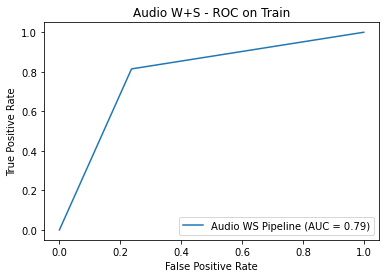

In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import tpot

if not os.path.isfile('tpot_exports/ws_audio_tpot.py'):
    pipe = tpot.TPOTClassifier(
        generations=2,
        population_size=18,
        offspring_size=3,
        cv=3,
        scoring="roc_auc",
        random_state=42,
        verbosity=2
    )
    pipe.fit(x_train, y_train)
    pipe.export("tpot_exports/ws_audio_tpot.py")

else:
    from sklearn.linear_model import SGDClassifier
    from sklearn.naive_bayes import BernoulliNB
    from sklearn.pipeline import make_pipeline, make_union
    from tpot.builtins import StackingEstimator
    from tpot.export_utils import set_param_recursive

    pipe = make_pipeline(
    StackingEstimator(estimator=SGDClassifier(alpha=0.01, eta0=0.01, fit_intercept=False, l1_ratio=0.5, learning_rate="invscaling", loss="perceptron", penalty="elasticnet", power_t=0.1)),
    BernoulliNB(alpha=1.0, fit_prior=False)
    )
    set_param_recursive(pipe.steps, 'random_state', 42)
    pipe.fit(x_train, y_train)

y_pred = pipe.predict(x_train)
print(pipe.score(x_train, y_train))
print("Accuracy:  ", round(accuracy_score(y_train,y_pred),4) )
print("Precision: ", round(precision_score(y_train,y_pred),4) )
print("Recall:    ", round(recall_score(y_train,y_pred),4) )
print("F1:        ", round(f1_score(y_train,y_pred),4) )

from sklearn import metrics
import matplotlib.pyplot as plt

fpr, tpr, thresholds = metrics.roc_curve(y_train, y_pred)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Audio WS Pipeline')
display.plot()  
plt.title("Audio W+S - ROC on Train")
plt.show()

Predicted labels:  246.0
Accuracy:   0.7357
Precision:  0.065
Recall:     0.5161
F1:         0.1155


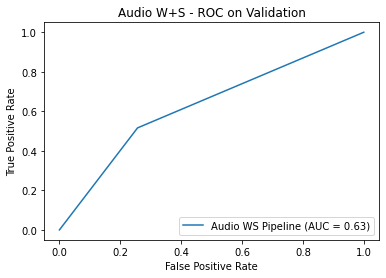

In [21]:
y_pred = pipe.predict(x_val)
print("Predicted labels: ", y_pred.sum())
#print(pipe.score(x_train_decomp, y_val))
print("Accuracy:  ", round(accuracy_score(y_val,y_pred),4) )
print("Precision: ", round(precision_score(y_val,y_pred),4) )
print("Recall:    ", round(recall_score(y_val,y_pred),4) )
print("F1:        ", round(f1_score(y_val,y_pred),4) )

fpr, tpr, thresholds = metrics.roc_curve(y_val, y_pred)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Audio WS Pipeline')
display.plot()  
plt.title("Audio W+S - ROC on Validation")
plt.show()

The classifier did not perform very well, it is comparable to the Kermit audio classifiers performance.